In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import ruptures as rpt
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

print("Libraries imported successfully")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully


In [2]:
df = pd.read_csv("../data/processed/chunked_with_changepoints.csv")

def parse_embedding(s):
    s_clean = s.strip("[]")
    return np.fromstring(s_clean, sep=" ")

df["embedding"] = df["embedding"].apply(parse_embedding)
print(f"Data loaded: {len(df)} rows")
print(f"Unique videos: {df['VideoTitle'].nunique()}")

Data loaded: 4031 rows
Unique videos: 101


In [ ]:
def extract_enhanced_features(embeddings):
    """Extract sophisticated semantic features with FIXED change point detection"""
    
    # novelties between consecutive chunks
    novelties = []
    for i in range(1, len(embeddings)):
        sim = cosine_similarity([embeddings[i]], [embeddings[i-1]])[0][0]
        novelties.append(1 - sim)
    
    if not novelties:
        return [0] * 10
    
    # Enhanced novelty features
    mean_novelty = np.mean(novelties)
    var_novelty = np.var(novelties)
    max_novelty = np.max(novelties)
    min_novelty = np.min(novelties)
    
    # Novelty trend
    try:
        trend_novelty = np.polyfit(range(len(novelties)), novelties, 1)[0]
    except:
        trend_novelty = 0
    
    # Rolling statistics
    recent_window = min(5, len(novelties))
    recent_novelty = np.mean(novelties[-recent_window:]) if recent_window > 0 else 0
    
    # FIXED CHANGE POINT DETECTION
    num_cps = 0
    cp_density = 0
    recent_cp_activity = 0
    cp_recency = 0
    
    if len(embeddings) >= 5:  # Need at least 5 chunks
        try:
            # Method 1: novelty sequence for change point detection
            novelty_array = np.array(novelties).reshape(-1, 1)
            
            # multiple approaches
            change_points = []
            
            # Approach 1: Based on novelty values
            try:
                model_cp = rpt.Pelt(model="l2").fit(novelty_array)
                cps = model_cp.predict(pen=3)
                if len(cps) > 1:
                    change_points.extend(cps[:-1])
            except:
                pass
            
            # Approach 2: Based on embedding similarity matrix
            try:
                # similarity matrix
                n = len(embeddings)
                sim_matrix = np.zeros((n, n))
                for i in range(n):
                    for j in range(n):
                        sim_matrix[i, j] = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
                
                # diagonal difference as signal
                diag_signal = []
                for i in range(1, n-1):
                    diag_signal.append(abs(sim_matrix[i, i-1] - sim_matrix[i, i+1]))
                
                if len(diag_signal) >= 3:
                    signal_array = np.array(diag_signal).reshape(-1, 1)
                    model_cp = rpt.Pelt(model="l1").fit(signal_array)
                    cps = model_cp.predict(pen=2)
                    if len(cps) > 1:
                        # diag_signal starts from index 1
                        change_points.extend([cp + 1 for cp in cps[:-1]])
            except:
                pass
            
            # Approach 3: Threshold-based detection on novelty
            try:
                novelty_threshold = np.mean(novelties) + 1.5 * np.std(novelties)
                threshold_cps = [i for i, nov in enumerate(novelties) if nov > novelty_threshold]
                change_points.extend(threshold_cps)
            except:
                pass
            
            # removing duplicates and sort
            change_points = sorted(list(set(change_points)))
            change_points = [cp for cp in change_points if 0 < cp < len(embeddings)]
            
            num_cps = len(change_points)
            
            if num_cps > 0:
                # change point density
                cp_density = num_cps / len(embeddings)
                
                # recent change point activity (last 30% of chunks)
                recent_threshold = int(0.7 * len(embeddings))
                recent_cps = sum(1 for cp in change_points if cp > recent_threshold)
                chunks_in_recent = len(embeddings) - recent_threshold
                recent_cp_activity = recent_cps / max(1, chunks_in_recent)
                
                # how recent is the last change point?
                last_cp = max(change_points)
                cp_recency = (len(embeddings) - last_cp) / len(embeddings)
                
        except Exception as e:
            # Fallback: Simple variance-based detection
            try:
                # rolling variance of novelty
                window_size = 3
                rolling_vars = []
                for i in range(window_size, len(novelties)):
                    window = novelties[i-window_size:i]
                    rolling_vars.append(np.var(window))
                
                if rolling_vars:
                    var_threshold = np.mean(rolling_vars) + np.std(rolling_vars)
                    num_cps = sum(1 for var in rolling_vars if var > var_threshold)
                    cp_density = num_cps / len(embeddings)
            except:
                pass
    
    return [mean_novelty, var_novelty, max_novelty, min_novelty, 
            trend_novelty, recent_novelty, num_cps, cp_density, 
            recent_cp_activity, cp_recency]

print("FIXED enhanced feature extraction function defined")

FIXED enhanced feature extraction function defined


In [ ]:
feature_rows = []
target_rows = []

print("Extracting features from videos...")
for video_title, group in df.groupby("VideoTitle"):
    group = group.reset_index(drop=True)
    total_chunks = len(group)
    embeddings = list(group["embedding"])
    
    # Starting from chunk 5 to have enough data for features
    for i in range(5, total_chunks):
        features = extract_enhanced_features(embeddings[:i])
        feature_rows.append(features)
        
        # Target: true completion %
        target_rows.append((i / total_chunks) * 100)

print(f"Generated {len(feature_rows)} training samples")

# Convert to numpy arrays
X = np.array(feature_rows)
y = np.array(target_rows)

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Extracting features from videos...
Generated 3526 training samples
Feature matrix shape: (3526, 10)
Target vector shape: (3526,)


In [ ]:
# average speech length
avg_speech_len = int(np.mean([len(g) for _, g in df.groupby("VideoTitle")]))
print(f"Average speech length (in chunks): {avg_speech_len}")

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaling features f
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print("Features have been scaled")

Average speech length (in chunks): 39
Training set size: 2820
Test set size: 706
Features have been scaled


## Load Baseline Model

In [ ]:
try:
    baseline_model = joblib.load("../model/random_forest_model.pkl")
    # handle different feature dimensions
    if hasattr(baseline_model, 'n_features_in_'):
        if baseline_model.n_features_in_ == X_test_scaled.shape[1]:
            baseline_pred = baseline_model.predict(X_test_scaled)
            baseline_mae = mean_absolute_error(y_test, baseline_pred)
            baseline_rmse = mean_squared_error(y_test, baseline_pred) ** 0.5
            print(f"Baseline Model Performance:")
            print(f"MAE: {baseline_mae:.2f}%")
            print(f"RMSE: {baseline_rmse:.2f}%")
        else:
            print("Baseline model has different feature dimensions. Will train new baseline.")
            baseline_mae = None
            baseline_rmse = None
    else:
        print("Cannot determine baseline model features. Will create comparison after tuning.")
        baseline_mae = None
        baseline_rmse = None
except FileNotFoundError:
    print("Baseline model not found. Will create comparison after tuning.")
    baseline_mae = None
    baseline_rmse = None

Baseline model has different feature dimensions. Will train new baseline.


## Define Hyperparameter Grid

In [9]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 15, 25, 35],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True]
}

print("Hyperparameter grid defined:")
print(f"Total combinations: {np.prod([len(v) for v in param_grid.values()])}")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

Hyperparameter grid defined:
Total combinations: 324
  n_estimators: [100, 200, 300]
  max_depth: [None, 15, 25, 35]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2', None]
  bootstrap: [True]


## Perform GridSearchCV

In [ ]:
print("Starting hyperparameter tuning...")
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

rf = RandomForestRegressor(random_state=42)

# negative MAE as scoring metric 
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
grid_search.fit(X_train_scaled, y_train)
end_time = time.time()

print(f"\nGrid search completed in {end_time - start_time:.2f} seconds")
print(f"End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Starting hyperparameter tuning...
Start time: 2025-07-13 13:48:54
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Grid search completed in 640.64 seconds
End time: 2025-07-13 13:59:35


## Display Best Parameters

In [ ]:
print("\n" + "="*50)
print("GRID SEARCH RESULTS")
print("="*50)

print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Score (negative MAE): {grid_search.best_score_:.4f}")
print(f"Best Cross-Validation MAE: {-grid_search.best_score_:.2f}%")

# the best model
best_model = grid_search.best_estimator_
print(f"\nBest model obtained")


GRID SEARCH RESULTS

Best Parameters:
  bootstrap: True
  max_depth: 25
  max_features: None
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 300

Best Cross-Validation Score (negative MAE): -6.3945
Best Cross-Validation MAE: 6.39%

Best model obtained


## Evaluate Tuned Model

In [ ]:
print("\n" + "="*50)
print("TEST SET EVALUATION")
print("="*50)

# Predicting on test set
y_pred_tuned = best_model.predict(X_test_scaled)

# metrics calculation
tuned_mae = mean_absolute_error(y_test, y_pred_tuned)
tuned_rmse = mean_squared_error(y_test, y_pred_tuned) ** 0.5
tuned_r2 = best_model.score(X_test_scaled, y_test)

print(f"\nTuned Model Performance:")
print(f"MAE: {tuned_mae:.2f}%")
print(f"RMSE: {tuned_rmse:.2f}%")
print(f"R² Score: {tuned_r2:.4f}")

# comparison with baseline if available
if baseline_mae is not None:
    print(f"\nComparison with Baseline:")
    print(f"MAE Improvement: {baseline_mae - tuned_mae:.2f}% ({((baseline_mae - tuned_mae) / baseline_mae * 100):.1f}% reduction)")
    print(f"RMSE Improvement: {baseline_rmse - tuned_rmse:.2f}% ({((baseline_rmse - tuned_rmse) / baseline_rmse * 100):.1f}% reduction)")


TEST SET EVALUATION

Tuned Model Performance:
MAE: 5.72%
RMSE: 8.12%
R² Score: 0.9036


## Feature Importance Analysis


FEATURE IMPORTANCE ANALYSIS

Feature Importance Ranking:
1. Num Change Points: 0.3361 (33.6%)
2. CP Density: 0.2022 (20.2%)
3. Max Novelty: 0.1021 (10.2%)
4. Min Novelty: 0.0860 (8.6%)
5. Trend Novelty: 0.0710 (7.1%)
6. CP Recency: 0.0620 (6.2%)
7. Mean Novelty: 0.0566 (5.7%)
8. Variance Novelty: 0.0499 (5.0%)
9. Recent Novelty: 0.0294 (2.9%)
10. Recent CP Activity: 0.0048 (0.5%)


/var/folders/xt/vj6ks3b53zjb91_6hzrc882c0000gn/T/ipykernel_2413/2805780558.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


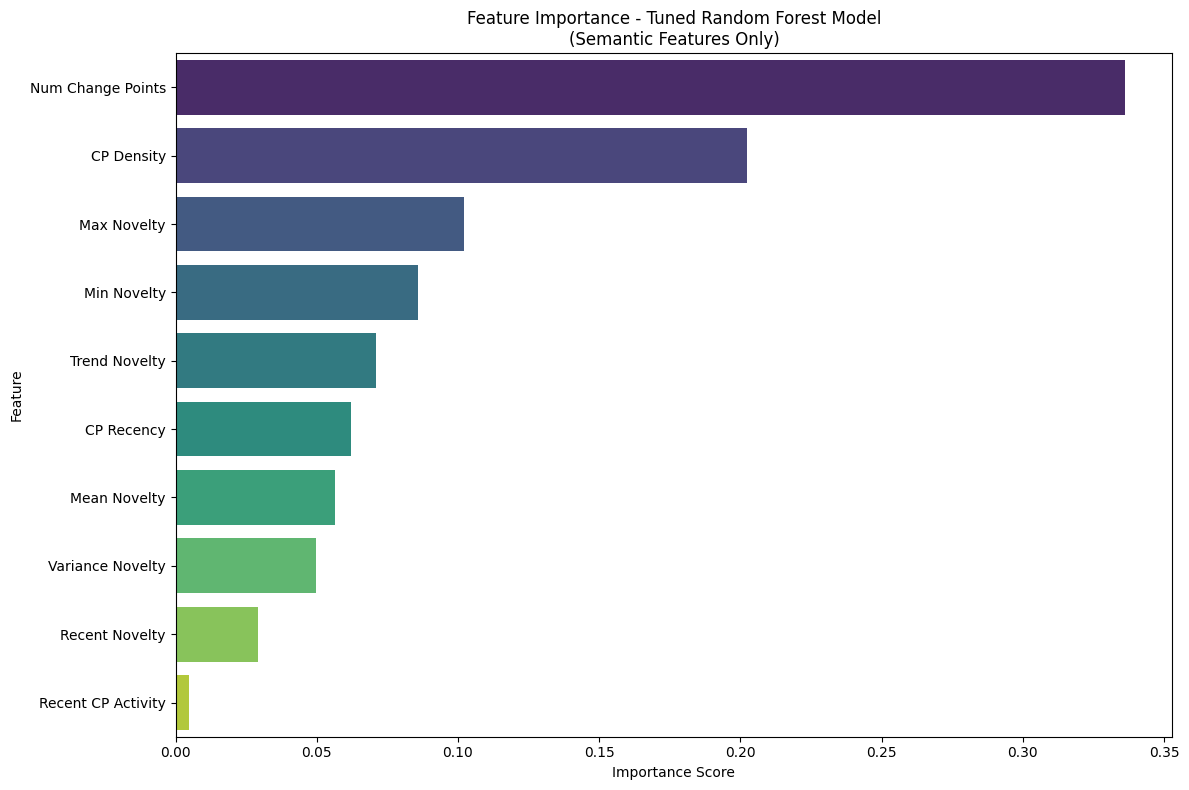

In [ ]:
feature_names = [
    'Mean Novelty', 'Variance Novelty', 'Max Novelty', 'Min Novelty',
    'Trend Novelty', 'Recent Novelty', 'Num Change Points', 'CP Density',
    'Recent CP Activity', 'CP Recency'
]
feature_importance = best_model.feature_importances_

print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# features by importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\nFeature Importance Ranking:")
for i, (_, row) in enumerate(importance_df.iterrows(), 1):
    print(f"{i}. {row['Feature']}: {row['Importance']:.4f} ({row['Importance']*100:.1f}%)")

# feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance - Tuned Random Forest Model\n(Semantic Features Only)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

## Visualize Predictions

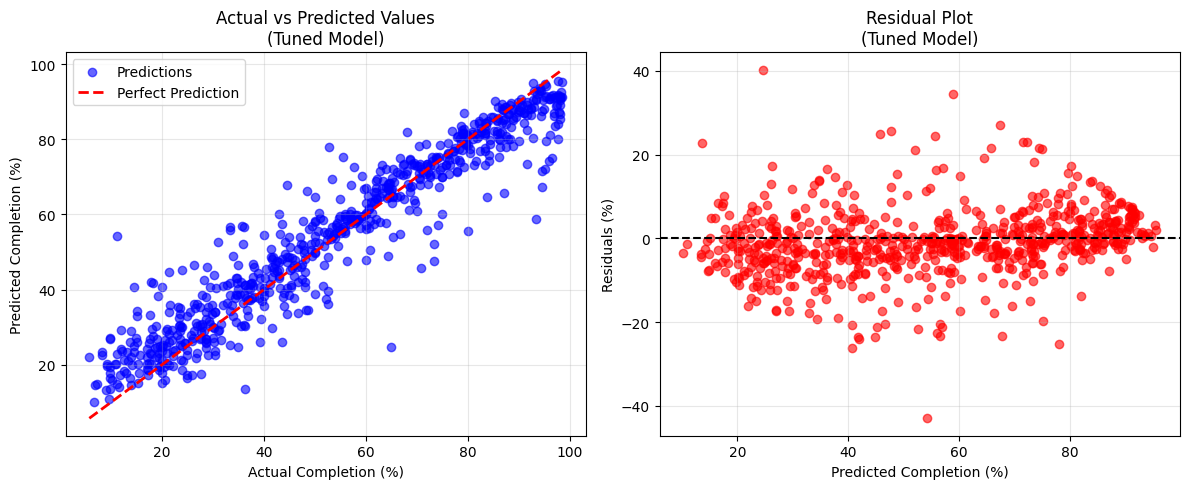


Residual Statistics:
Mean Residual: -0.8881%
Std Residual: 8.0747%


In [ ]:
plt.figure(figsize=(12, 5))

# Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_tuned, alpha=0.6, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Completion (%)')
plt.ylabel('Predicted Completion (%)')
plt.title('Actual vs Predicted Values\n(Tuned Model)')
plt.legend()
plt.grid(True, alpha=0.3)

# Residual plot
plt.subplot(1, 2, 2)
residuals = y_test - y_pred_tuned
plt.scatter(y_pred_tuned, residuals, alpha=0.6, color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Completion (%)')
plt.ylabel('Residuals (%)')
plt.title('Residual Plot\n(Tuned Model)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional statistics
print(f"\nResidual Statistics:")
print(f"Mean Residual: {np.mean(residuals):.4f}%")
print(f"Std Residual: {np.std(residuals):.4f}%")

In [ ]:
#Saving the Tuned Model

model_filename = "../model/tuned_random_forest_model.pkl"
joblib.dump(best_model, model_filename)
print(f"\nTuned model saved as: {model_filename}")

# Saving hyperparameters for reference
import json
params_filename = "../model/best_hyperparameters.json"
with open(params_filename, 'w') as f:
    json.dump(grid_search.best_params_, f, indent=2)
print(f"Best hyperparameters saved as: {params_filename}")


Tuned model saved as: ../model/tuned_random_forest_model.pkl
Best hyperparameters saved as: ../model/best_hyperparameters.json


## Updated Prediction Function

In [ ]:
def predict_progress_live_tuned(partial_embeddings, reg_model, scaler, avg_speech_len):
    """
    Predict speech completion progress using the tuned model with enhanced features.
    
    Args:
        partial_embeddings: List of embeddings processed so far
        reg_model: Trained RandomForest model (tuned)
        scaler: StandardScaler used during training
        avg_speech_len: Average speech length for normalization
    
    Returns:
        Predicted completion percentage (0-100)
    """
    i = len(partial_embeddings)
    if i < 5:  # Need at least 5 chunks for enhanced features
        return (i / avg_speech_len) * 100  
    
    # enhanced features extraction (returns 10 features)
    features = extract_enhanced_features(partial_embeddings)
    
    # scaling features using the same scaler from training
    features_scaled = scaler.transform([features])
    
    # predict
    pred = reg_model.predict(features_scaled)[0]
    return min(max(pred, 0), 100)

def predict_progress_live_tuned_simple(partial_embeddings, reg_model, avg_speech_len):
    """
    Predict speech completion progress using the tuned model with enhanced features.
    Note: This version doesn't scale features, which may reduce accuracy.
    
    Args:
        partial_embeddings: List of embeddings processed so far
        reg_model: Trained RandomForest model (tuned)
        avg_speech_len: Average speech length for normalization
    
    Returns:
        Predicted completion percentage (0-100)
    """
    i = len(partial_embeddings)
    if i < 5:  # Need at least 5 chunks for enhanced features
        return (i / avg_speech_len) * 100  
    
    # enhanced features extraction (returns 10 features)
    features = extract_enhanced_features(partial_embeddings)
    
    # predict (without scaling - may be less accurate)
    pred = reg_model.predict([features])[0]
    return min(max(pred, 0), 100)

print("Fixed prediction functions defined successfully")

Fixed prediction functions defined successfully


In [ ]:
# Testing the tuned model on ALL chunks of a single speech
video_title = "75th UN General Assembly Speech"
sample_group = df[df["VideoTitle"] == video_title].reset_index(drop=True)

if len(sample_group) > 0:
    print(f"\nTesting tuned model on: {video_title}")
    print(f"Total chunks in video: {len(sample_group)}")
    
    print("\nTuned Model Performance - ALL CHUNKS:")
    print("-" * 45)
    print(f"{'Chunk':<6} {'True %':<8} {'Tuned %':<10} {'Error':<8}")
    print("-" * 45)
    
    all_errors = []
    
    for chunk_count in range(5, len(sample_group) + 1):
        partial_embeddings = list(sample_group["embedding"][:chunk_count])
        
        # True progress
        true_progress = (chunk_count / len(sample_group)) * 100
        
        # Tuned model prediction
        tuned_pred = predict_progress_live_tuned(partial_embeddings, best_model, scaler, avg_speech_len)
        
        # Calculate error
        error = abs(true_progress - tuned_pred)
        all_errors.append(error)
        
        print(f"{chunk_count:<6} {true_progress:<8.1f} {tuned_pred:<10.1f} {error:<8.1f}")
    
    print("-" * 45)
    
    # Summary statistics for this speech
    print(f"\nSummary Statistics:")
    print(f"Total predictions: {len(all_errors)}")
    print(f"Average error: {np.mean(all_errors):.2f}%")
    print(f"Median error: {np.median(all_errors):.2f}%")
    print(f"Maximum error: {np.max(all_errors):.2f}%")
    print(f"Minimum error: {np.min(all_errors):.2f}%")
    print(f"Standard deviation: {np.std(all_errors):.2f}%")
    
    # Error distribution
    print(f"\nError Distribution:")
    print(f"Errors ≤ 2%:  {np.sum(np.array(all_errors) <= 2) / len(all_errors) * 100:.1f}% of predictions")
    print(f"Errors ≤ 5%:  {np.sum(np.array(all_errors) <= 5) / len(all_errors) * 100:.1f}% of predictions")
    print(f"Errors ≤ 10%: {np.sum(np.array(all_errors) <= 10) / len(all_errors) * 100:.1f}% of predictions")
    
else:
    print(f"Video '{video_title}' not found in dataset.")


Testing tuned model on: 75th UN General Assembly Speech
Total chunks in video: 43

Tuned Model Performance - ALL CHUNKS:
---------------------------------------------
Chunk  True %   Tuned %    Error   
---------------------------------------------
5      11.6     14.1       2.5     
6      14.0     14.5       0.5     
7      16.3     16.0       0.3     
8      18.6     17.7       0.9     
9      20.9     21.5       0.6     
10     23.3     23.2       0.0     
11     25.6     22.5       3.1     
12     27.9     27.2       0.7     
13     30.2     26.1       4.2     
14     32.6     30.3       2.3     
15     34.9     34.6       0.3     
16     37.2     37.5       0.3     
17     39.5     37.9       1.6     
18     41.9     36.3       5.5     
19     44.2     42.5       1.7     
20     46.5     48.0       1.4     
21     48.8     50.0       1.1     
22     51.2     52.4       1.2     
23     53.5     56.0       2.5     
24     55.8     59.0       3.2     
25     58.1     58.2       0.1